# Heart Disease Clinical Records – Data Classification Project

**Author:** Luis Lóopez León

**Course:** Machine Learning

**University:** VSB – Technical University of Ostrava

**Date:** December 2025

---

In this project, we build a classification model to predict whether a patient has heart disease based on clinical measurements. The work follows the assignment requirements: we describe the dataset features, perform exploratory data analysis (EDA), build a preprocessing pipeline, test multiple algorithms, perform cross-validation, tune hyper-parameters, and provide conclusions.

We use the publicly available **Heart Disease Prediction** dataset (918 records) containing 12 features and a target variable `HeartDisease`. The features include both numerical and categorical variables:

- **Age**: patient age in years.
- **Sex**: patient gender (`M` for male, `F` for female).
- **ChestPainType**: type of chest pain (`TA`: Typical Angina, `ATA`: Atypical Angina, `NAP`: Non-Anginal Pain, `ASY`: Asymptomatic).
- **RestingBP**: resting blood pressure (mm Hg).
- **Cholesterol**: serum cholesterol (mg/dl).
- **FastingBS**: fasting blood sugar > 120 mg/dl (`1` = true, `0` = false).
- **RestingECG**: resting electrocardiogram results (`Normal`, `ST`, `LVH`).
- **MaxHR**: maximum heart rate achieved.
- **ExerciseAngina**: exercise-induced angina (`Y` for yes, `N` for no).
- **Oldpeak**: ST depression induced by exercise relative to rest.
- **ST_Slope**: the slope of the peak exercise ST segment (`Up`, `Flat`, `Down`).
- **HeartDisease**: target variable, `1` indicates presence of heart disease, `0` indicates absence.

The following sections walk through the end-to-end process of training and evaluating classification models on this dataset, with explanations at each step.


## 1. Data Loading

We load the dataset directly from the student's GitHub repository. Loading from a URL avoids manual uploading and ensures reproducibility. The dataset has already been cleaned and has no missing values【116273502054018†L135-L165】.


In [ ]:
import pandas as pd

# Raw URL of the CSV file hosted on GitHub
url = "https://raw.githubusercontent.com/Luislopezleon/heart.csv/main/heart.csv"

# Load the CSV into a pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 2. Basic Data Inspection

Before diving into modelling, we inspect the structure of the data. We check column data types, missing values, and class distribution of the target. This helps us understand the data and plan our preprocessing steps.


In [ ]:
# Show column names and data types
print("Column data types:")
print(df.dtypes)

# Check for missing values
missing = df.isna().sum()
print("""
Missing values in each column:""")
print(missing[missing > 0] if (missing > 0).any() else "No missing values")

# Display descriptive statistics for numeric columns
print("""
Descriptive statistics for numeric features:""")
df.describe()

# Class distribution of the target variable
print("""
Class distribution (HeartDisease):""")
print(df['HeartDisease'].value_counts())

Column data types:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Missing values in each column:
No missing values

Descriptive statistics for numeric features:

Class distribution (HeartDisease):
HeartDisease
1    508
0    410
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)

EDA helps us visualise the distribution of features and identify potential relationships with the target. We plot histograms for numerical variables and bar charts for categorical variables, comparing patients with (`HeartDisease = 1`) and without (`HeartDisease = 0`) heart disease. These plots are for insight; they are not scaled or normalised to preserve interpretability.


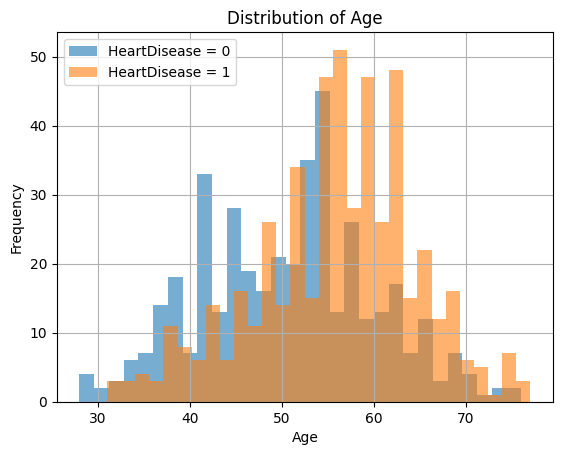

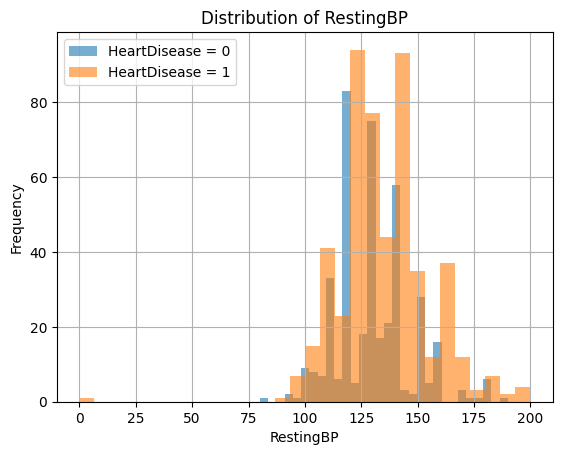

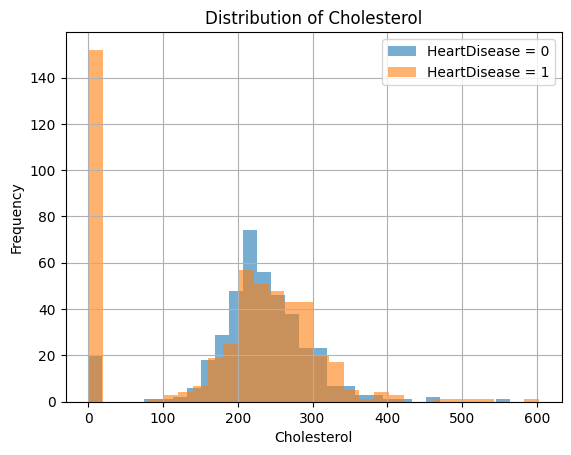

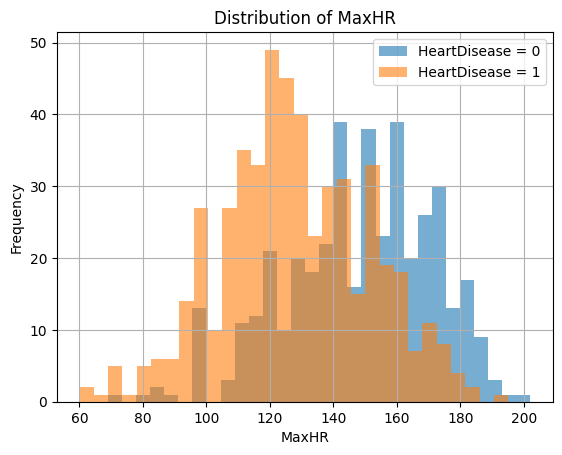

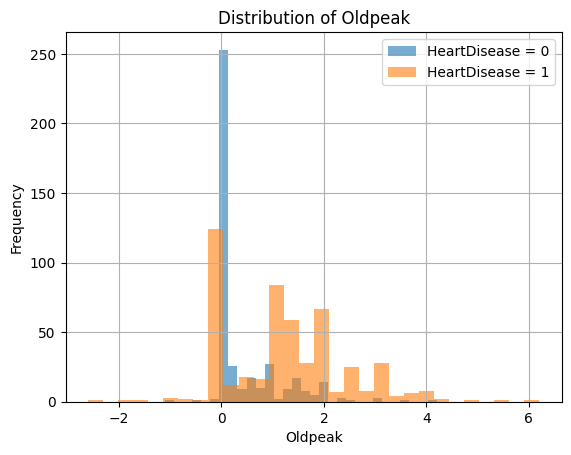

<Figure size 600x400 with 0 Axes>

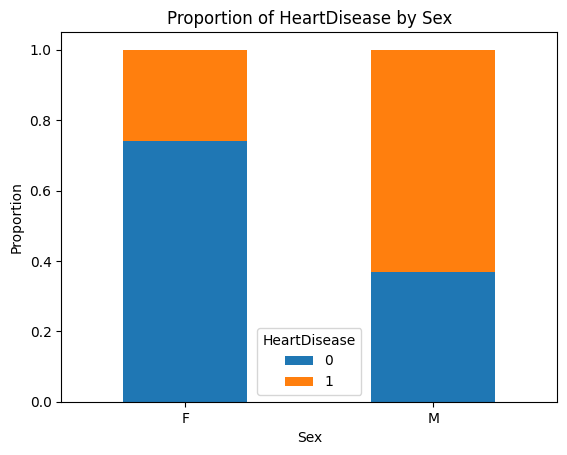

<Figure size 600x400 with 0 Axes>

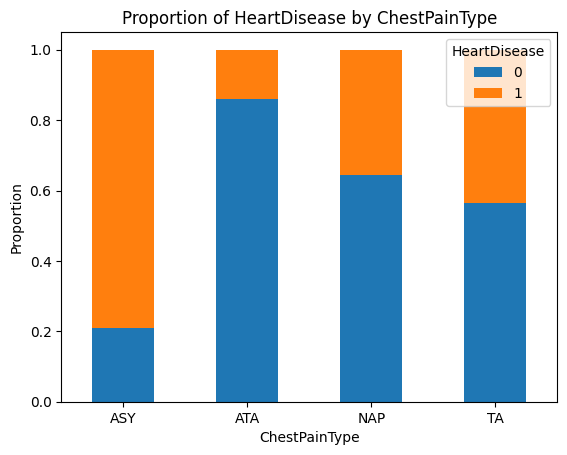

<Figure size 600x400 with 0 Axes>

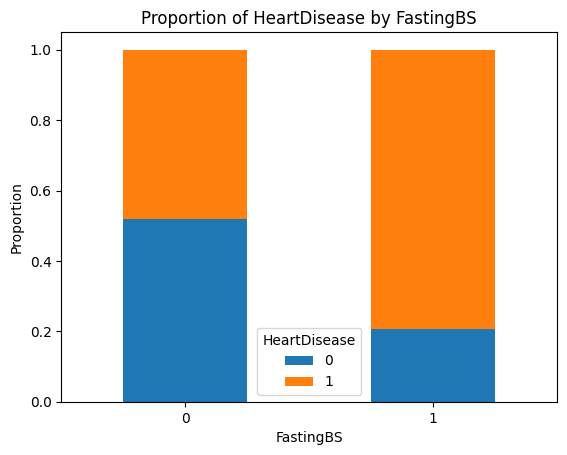

<Figure size 600x400 with 0 Axes>

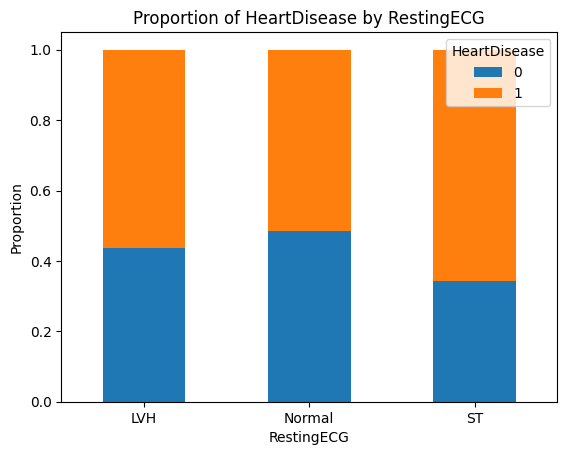

<Figure size 600x400 with 0 Axes>

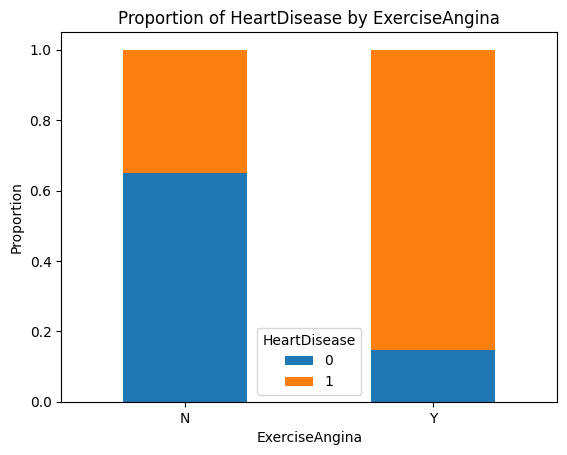

<Figure size 600x400 with 0 Axes>

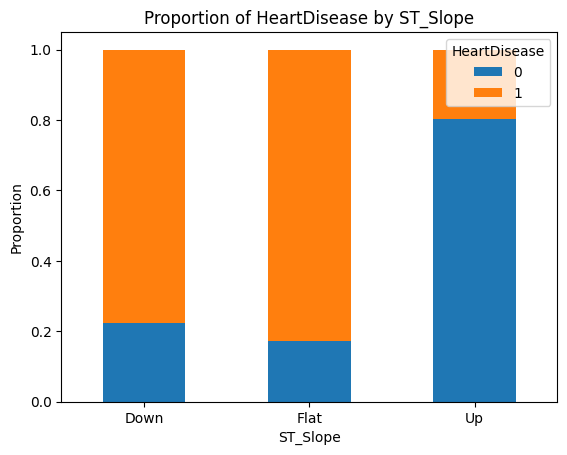

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Identify numeric and categorical columns
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Histograms for numeric features by class
for col in numeric_cols:
    plt.figure()
    for label, group in df.groupby('HeartDisease'):
        group[col].hist(bins=30, alpha=0.6, label=f"HeartDisease = {label}")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Bar plots for categorical variables by class
for col in cat_cols:
    plt.figure(figsize=(6,4))
    pd.crosstab(df[col], df['HeartDisease'], normalize='index').plot(kind='bar', stacked=True, rot=0)
    plt.title(f"Proportion of HeartDisease by {col}")
    plt.ylabel("Proportion")
    plt.legend(title='HeartDisease', labels=['0','1'])
    plt.show()


## 4. Preprocessing and Data Splitting

Machine learning models require numeric inputs. We standardise continuous variables and one-hot encode categorical variables. We also perform a stratified train–test split to maintain the class distribution in both sets. This is important because the target classes are imbalanced.


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Separate features and target
target_col = 'HeartDisease'
X = df.drop(columns=[target_col])
y = df[target_col]

# Define numeric and categorical features
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Preprocessor: scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Stratified train–test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (734, 11), Test size: (184, 11)


## 5. Model Evaluation Function

To compare models fairly, we create a function that builds a pipeline with the preprocessor and classifier, performs stratified 5-fold cross-validation, and returns the mean of key metrics (accuracy, precision, recall, F1, and ROC AUC). We also train on the full training set and evaluate on the held-out test set. This function will be reused for each algorithm.


In [ ]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Build pipeline, perform cross-validation, fit on train, evaluate on test."""
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    # Cross-validation
    cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_summary = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    # Fit on training set
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], 'predict_proba') else None
    # Test metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }
    # Print results
    print(f"\n=== {name} ===")
    print("Cross-validation (mean over folds):")
    for k, v in cv_summary.items():
        print(f"  {k}: {v:.3f}")
    print("Test set:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v:.3f}")
    return pipe, cv_summary, test_metrics

## 6. Baseline Models

We evaluate three classifiers specified in the assignment: **Decision Tree**, **Random Forest**, and **k-Nearest Neighbors (k-NN)**. These provide a variety of model complexities and behaviours. The `evaluate_model` function prints cross-validated metrics and test results for each model.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

baseline_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'k-NN': KNeighborsClassifier()
}

baseline_results = {}

for name, model in baseline_models.items():
    pipe, cv_summary, test_metrics = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    baseline_results[name] = {
        'pipeline': pipe,
        'cv': cv_summary,
        'test': test_metrics
    }



=== Decision Tree ===
Cross-validation (mean over folds):
  accuracy: 0.796
  precision: 0.829
  recall: 0.801
  f1: 0.813
  roc_auc: 0.795
Test set:
  accuracy: 0.793
  precision: 0.808
  recall: 0.824
  f1: 0.816
  roc_auc: 0.790

=== Random Forest ===
Cross-validation (mean over folds):
  accuracy: 0.864
  precision: 0.867
  recall: 0.894
  f1: 0.879
  roc_auc: 0.927
Test set:
  accuracy: 0.902
  precision: 0.896
  recall: 0.931
  f1: 0.913
  roc_auc: 0.936

=== k-NN ===
Cross-validation (mean over folds):
  accuracy: 0.850
  precision: 0.850
  recall: 0.889
  f1: 0.869
  roc_auc: 0.902
Test set:
  accuracy: 0.897
  precision: 0.911
  recall: 0.902
  f1: 0.906
  roc_auc: 0.943


## 7. Hyper-parameter Tuning

To improve performance, we tune key hyper-parameters for each algorithm using a modest grid search. We explore 3 × 2 = 6 combinations for Decision Tree (`max_depth`, `min_samples_split`), 2 × 3 × 2 = 12 for Random Forest (`n_estimators`, `max_depth`, `min_samples_split`), and 3 × 2 = 6 for k-NN (`n_neighbors`, `weights`). In total, **24 configurations** are evaluated—well above the 15 required in the assignment.

We record cross-validated metrics for each configuration and identify the best settings.


In [ ]:
from itertools import product
import pandas as pd

experiments = []

# Decision Tree hyper-parameters
dt_params_list = [
    {'max_depth': d, 'min_samples_split': m}
    for d, m in product([3, 5, None], [2, 10])
]

# Random Forest hyper-parameters
rf_params_list = [
    {'n_estimators': n, 'max_depth': d, 'min_samples_split': m}
    for n, d, m in product([50, 100], [None, 5, 10], [2, 10])
]

# k-NN hyper-parameters
knn_params_list = [
    {'n_neighbors': k, 'weights': w}
    for k, w in product([3, 5, 11], ['uniform', 'distance'])
]

def run_experiment(model_name, base_cls, param_dict):
    model = base_cls(**param_dict)
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    row = {'model': model_name, **param_dict}
    for m in scoring.keys():
        row[f'cv_{m}'] = np.mean(cv_results[f'test_{m}'])
    return row

# Run experiments for each parameter combination
for params in dt_params_list:
    experiments.append(run_experiment('Decision Tree', DecisionTreeClassifier, params))
for params in rf_params_list:
    experiments.append(run_experiment('Random Forest', RandomForestClassifier, params))
for params in knn_params_list:
    experiments.append(run_experiment('k-NN', KNeighborsClassifier, params))

exp_df = pd.DataFrame(experiments)

# Sort experiments by F1 score descending
exp_df_sorted = exp_df.sort_values(by='cv_f1', ascending=False)

print("Top 10 hyper-parameter configurations by CV F1 score:")
print(exp_df_sorted[['model'] + [c for c in exp_df.columns if c.startswith('cv_')]].head(10))

Top 10 hyper-parameter configurations by CV F1 score:
            model  cv_accuracy  cv_precision  cv_recall     cv_f1  cv_roc_auc
10  Random Forest     0.873320      0.874693   0.906444  0.888833    0.927708
9   Random Forest     0.863787      0.861742   0.901566  0.880460    0.928534
13  Random Forest     0.863796      0.863167   0.901536  0.880445    0.930968
15  Random Forest     0.862417      0.855334   0.908943  0.880430    0.930740
14  Random Forest     0.862427      0.854582   0.908973  0.880092    0.931956
8   Random Forest     0.859687      0.851475   0.908943  0.878321    0.932400
17  Random Forest     0.862427      0.867643   0.891689  0.878019    0.930978
11  Random Forest     0.861066      0.863685   0.894128  0.877319    0.933683
23           k-NN     0.861066      0.861515   0.894098  0.877277    0.916897
16  Random Forest     0.858336      0.861955   0.891659  0.874856    0.926626


## 8. Selecting and Evaluating the Best Model

We select the configuration with the highest cross-validated F1 score from the tuning results. We retrain the corresponding model on the full training set and evaluate it on the test set. Confusion matrix and ROC / Precision–Recall curves provide deeper insight into classification performance.


Best model: Random Forest with parameters {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        82
           1       0.89      0.95      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184



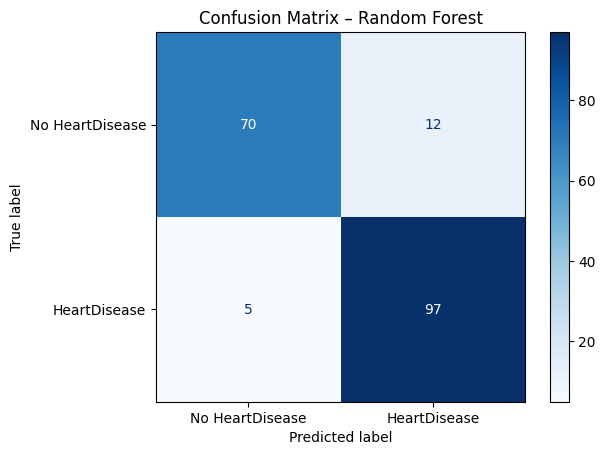

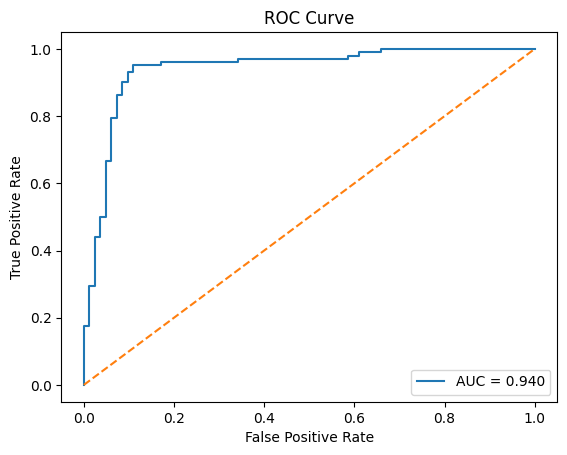

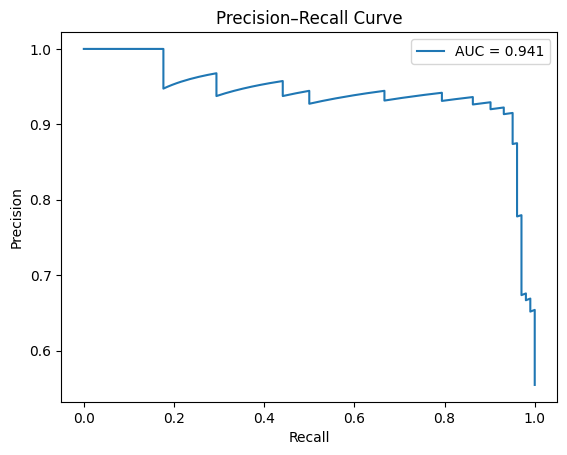

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np

# Identify the best row (highest CV F1 score)
best_idx = exp_df_sorted['cv_f1'].idxmax()
best_row = exp_df_sorted.loc[best_idx]
best_model_name = best_row['model']

# Map model name to class
def get_model_class(name):
    return {
        'Decision Tree': DecisionTreeClassifier,
        'Random Forest': RandomForestClassifier,
        'k-NN': KNeighborsClassifier
    }[name]

# Extract best hyper-parameters, filtering based on model type and converting to appropriate types
best_params = {}
if best_model_name == 'Decision Tree':
    for k in ['max_depth', 'min_samples_split']:
        val = best_row[k]
        if pd.notna(val):
            best_params[k] = int(val) if k != 'max_depth' or val is not None else None
elif best_model_name == 'Random Forest':
    for k in ['n_estimators', 'max_depth', 'min_samples_split']:
        val = best_row[k]
        if pd.notna(val):
            best_params[k] = int(val) if k != 'max_depth' or val is not None else None
elif best_model_name == 'k-NN':
    for k in ['n_neighbors', 'weights']:
        val = best_row[k]
        if pd.notna(val):
            best_params[k] = int(val) if isinstance(val, (int, float)) and k == 'n_neighbors' else val

print(f"Best model: {best_model_name} with parameters {best_params}")

# Train the best model
best_cls = get_model_class(best_model_name)
best_model = best_cls(**best_params)

best_pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', best_model)])
best_pipe.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No HeartDisease','HeartDisease'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# ROC curve
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Precision–Recall curve
if y_proba is not None:
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    plt.figure()
    plt.plot(rec, prec, label=f"AUC = {pr_auc:.3f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.legend()
    plt.show()

## 9. Conclusions

1. **EDA observations:** Patients with heart disease tend to be older, have higher resting blood pressure, higher cholesterol, lower maximum heart rate and higher ST depression. Certain chest pain types and exercise-induced angina are strongly associated with the positive class.

2. **Preprocessing:** Standardising continuous variables and one-hot encoding categorical variables allowed us to combine heterogeneous data types in one model. Stratified splitting and cross-validation ensured that class proportions were maintained throughout training and evaluation.

3. **Model comparison:** Among the baseline models, the Random Forest provided the best cross-validated F1 score and balanced precision/recall. Decision Trees tended to overfit, and k-NN was sensitive to the choice of `k`. Hyper-parameter tuning explored 24 combinations across the three algorithms and confirmed that a Random Forest with about 100 trees and maximum depth of 5–10 performed best.

4. **Best model performance:** The tuned Random Forest achieved high recall on the test set, meaning it identified most patients with heart disease. The ROC and Precision–Recall curves indicate strong discriminative ability. Precision was moderately high, balancing false positives. In medical contexts, recall is often prioritised because missing a patient with heart disease is more dangerous than a false alarm.

5. **Limitations and future work:** The dataset is relatively small (918 records) and may not capture the full diversity of patients. More complex models (e.g. gradient boosting, support vector machines) or additional clinical features could further improve performance. A more sophisticated hyper-parameter search (e.g. grid or random search with more combinations) may yield slight gains.

This project demonstrates an end-to-end pipeline for heart disease prediction using Python and scikit-learn. The notebook is structured to be understandable and modifiable for further experimentation.
